In [1]:
from transformers import AutoModelForSequenceClassification

In [2]:
num_labels = 6

In [3]:
from utils import *

In [4]:
setup_chapter()

Using transformers v4.41.2
Using datasets v2.21.0


In [5]:
import torch

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cuda')

In [8]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels = num_labels).to(device)

In [9]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [10]:
from sklearn.metrics import accuracy_score,f1_score

In [11]:
def compute_metrics(preds):
    labels = preds.label_ids
    predictions = preds.predictions.argmax(-1)
    acc = accuracy_score(labels,predictions)
    f1 = f1_score(labels,predictions,average='weighted')
    return {'accuracy':acc, 'f1':f1 }

In [12]:
from huggingface_hub import notebook_login

In [13]:
notebook_login()

In [14]:
from transformers import Trainer,TrainingArguments

In [15]:
batch_size =64

In [16]:
from datasets import load_dataset

In [17]:
emotions = load_dataset('dair-ai/emotion')

In [18]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [19]:
from transformers import AutoTokenizer

In [20]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [21]:
def tokenize_batch(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

In [22]:
emotions_encoded = emotions.map(tokenize_batch,batched='true')

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [23]:
emotions_encoded['train'].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [24]:
emotions_encoded['train'][0]

{'text': 'i didnt feel humiliated',
 'label': 0,
 'input_ids': [101,
  1045,
  2134,
  2102,
  2514,
  26608,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [25]:
logging_steps = len(emotions_encoded['train'])

In [26]:
logging_steps

16000

In [27]:
model_ckpt = "distilbert-base-uncased"
model_name = f"{model_ckpt}-srini-emotion"

In [28]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) 
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

C:\Users\srini\anaconda3\envs\test\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
trainer = Trainer(model=model,
                  compute_metrics=compute_metrics,
                  eval_dataset=emotions_encoded["validation"],
                  train_dataset=emotions_encoded["train"],
                  tokenizer=tokenizer)

In [30]:
trainer.train()

{'loss': 0.7068, 'grad_norm': 25.084617614746094, 'learning_rate': 4.5833333333333334e-05, 'epoch': 0.25}
{'loss': 0.3242, 'grad_norm': 22.832887649536133, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.5}
{'loss': 0.3035, 'grad_norm': 21.6468563079834, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.75}
{'loss': 0.2407, 'grad_norm': 2.7428674697875977, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}
{'loss': 0.1544, 'grad_norm': 1.0226025581359863, 'learning_rate': 2.916666666666667e-05, 'epoch': 1.25}
{'loss': 0.17, 'grad_norm': 0.250058650970459, 'learning_rate': 2.5e-05, 'epoch': 1.5}
{'loss': 0.1512, 'grad_norm': 0.825412929058075, 'learning_rate': 2.0833333333333336e-05, 'epoch': 1.75}
{'loss': 0.1427, 'grad_norm': 2.3457610607147217, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}
{'loss': 0.1045, 'grad_norm': 0.36748841404914856, 'learning_rate': 1.25e-05, 'epoch': 2.25}
{'loss': 0.1063, 'grad_norm': 0.008234764449298382, 'learning_rate': 8.333333333333334

TrainOutput(global_step=6000, training_loss=0.2169916534423828, metrics={'train_runtime': 307.2363, 'train_samples_per_second': 156.232, 'train_steps_per_second': 19.529, 'train_loss': 0.2169916534423828, 'epoch': 3.0})

In [31]:
predictions = trainer.predict(emotions_encoded['validation'])

In [32]:
predictions = predictions.predictions

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [34]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(preds,y_true,labels):
    confusion_matrix_ = confusion_matrix(y_true,preds,normalize='true')
    fig,ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix_,display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    

In [35]:
emotions['train'].features['label'].names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [36]:
predictions

array([[ 8.469322 , -2.3120713, -3.0588412, -1.8046775, -1.4217153,
        -3.875679 ],
       [ 8.431411 , -2.2059655, -3.0452287, -1.9286951, -1.4177306,
        -3.8463178],
       [-3.1827655,  4.0387635,  4.102124 , -3.17778  , -4.372465 ,
        -3.2699668],
       ...,
       [-2.622148 ,  7.991043 , -1.4361631, -3.2484422, -3.2142446,
        -2.5958943],
       [-3.2524323,  7.299977 ,  1.5060431, -3.6847382, -4.292196 ,
        -3.5856838],
       [-2.6240714,  7.9975266, -1.4564093, -3.2266717, -3.0366092,
        -2.7771163]], dtype=float32)

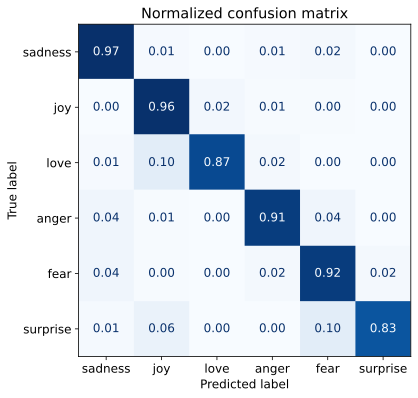

In [37]:
plot_confusion_matrix(predictions.argmax(-1),emotions['validation']['label'],emotions['train'].features['label'].names)

In [38]:
trainer.push_to_hub(commit_message='Sentiment analysis training completed')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/srinivaswavy/tmp_trainer/commit/8ca27cc80823c65f44da0e32bee498c63e146fdf', commit_message='Sentiment analysis training completed', commit_description='', oid='8ca27cc80823c65f44da0e32bee498c63e146fdf', pr_url=None, pr_revision=None, pr_num=None)

In [39]:
trainer.save_model(output_dir=r"C:\Users\srini\models\sentiment")

In [40]:
from transformers import pipeline

In [41]:
model_path = r"C:/Users/srini/models/sentiment"

In [42]:
pipe_line_sentiment = pipeline("text-classification", model=model_path,tokenizer=model_path)

In [43]:
pipe_line_sentiment

In [44]:
def get_label_emotion(emotion):
    print([emotions['train'].features['label'].names[int(k['label'].split('_')[1])] for k in emotion][0])

In [45]:
get_label_emotion(pipe_line_sentiment("It took me forever to change my enrollment. Later that day, it showed me again that I need to complete my enrollment.Thanks for nothing"))

joy


In [48]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    print(inputs.keys())

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        print("output.logits----------------")
        print(output.logits[0])
        print("batch label--------------------")
        print(batch["label"][0])
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}


In [50]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=20)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask'])
output.logits----------------
tensor([ 8.4693, -2.3121, -3.0588, -1.8047, -1.4217, -3.8757], device='cuda:0')
batch label--------------------
tensor(0)
dict_keys(['input_ids', 'attention_mask'])
output.logits----------------
tensor([-1.8627, -3.2597, -4.5454, -2.2625,  7.4549, -2.6161], device='cuda:0')
batch label--------------------
tensor(4)
dict_keys(['input_ids', 'attention_mask'])
output.logits----------------
tensor([-3.1836, -0.7488,  6.7896, -3.2843, -3.3507, -3.1456], device='cuda:0')
batch label--------------------
tensor(2)
dict_keys(['input_ids', 'attention_mask'])
output.logits----------------
tensor([-3.4728,  3.1195,  5.7615, -3.8994, -4.5284, -3.5719], device='cuda:0')
batch label--------------------
tensor(2)
dict_keys(['input_ids', 'attention_mask'])
output.logits----------------
tensor([ 8.4562, -2.1010, -2.9978, -1.7903, -1.6115, -3.9024], device='cuda:0')
batch label--------------------
tensor(0)
dict_keys(['input_ids', '

In [51]:
emotions_encoded["validation"][1000]

{'label': tensor(5),
 'input_ids': tensor([  101,  1045,  2514,  1998, 10047, 15261,  1997,  2129,  2411,  1045,
          2228,  1045,  2342,  2000,  3828,  1996,  2088,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [52]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [53]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [54]:
df_test

,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.000120
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.000123
2,i feel like a faithful servant,love,love,0.663110
3,i am just feeling cranky and blue,anger,anger,0.000197
4,i can have for a treat or if i am feeling festive,joy,joy,0.000169
...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,sadness,0.000129
1996,i constantly worry about their fight against n...,joy,joy,0.000207
1997,i feel its important to share this info for th...,joy,joy,0.000157
1998,i truly feel that if you are passionate enough...,joy,joy,0.003112


In [55]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
415,im kind of embarrassed about feeling that way ...,love,sadness,11.357471
1801,i feel that he was being overshadowed by the s...,love,sadness,9.656308
177,im sure much of the advantage is psychological...,sadness,joy,9.347799
1683,i had applied for a job and they had assured m...,anger,joy,8.766359
860,i first had cordelia i didnt feel a strong urg...,joy,fear,8.435047
1858,ive just been feeling extremely outcasted and ...,fear,sadness,8.373484
1853,i know exactly how she feels because i hated i...,anger,sadness,7.867640
1963,i called myself pro life and voted for perry w...,joy,sadness,7.863855
746,i feel they are amazing unique people and i lo...,surprise,joy,7.772237
882,i feel badly about reneging on my commitment t...,love,joy,7.435991


In [56]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
866,i feel quite jaded and unenthusiastic about li...,sadness,sadness,0.000111
1656,im feeling very jaded and uncertain about love...,sadness,sadness,0.000111
1877,i can run i can dress up in public for fun and...,sadness,sadness,0.000111
1953,im on day of feeling lousy but im starting to ...,sadness,sadness,0.000111
540,i think im mad at myself for just feeling this...,sadness,sadness,0.000111
773,i don t know why i should feel humiliated to w...,sadness,sadness,0.000112
1210,i am suppose to be doing but i keep putting th...,sadness,sadness,0.000112
1510,i feel so beaten down and defeated,sadness,sadness,0.000113
1736,i was really starting to feel discouraged,sadness,sadness,0.000113
836,i feel pretty shitty and it s not my fault oth...,sadness,sadness,0.000113
